# Fractional GD

In [2]:
library('fracdiff')

Warning message:
"package 'fracdiff' was built under R version 4.1.3"


## Wectorized Caputo derivative.

In [1]:
caputo.derivative <- function(x, s, deriv, a=0)
{   
    if(deriv(x)==0){return(0)}
    integrand <- function(tau) {(1/gamma(1-s))*deriv(tau)/(x-tau)**s}
    return(integrate(integrand, lower = a, upper = x)$value)
}
v.caputo.derivative <- Vectorize(caputo.derivative, "x")

In [52]:
generate_data <- function(n=200, d=100, s=2, seed =42) 
{
    set.seed(seed)
    beta <- numeric(length = d)
    beta [1:s] <- 1
    X <- matrix(rnorm(n*d), nrow=n, ncol=d)
    y <- c(X %*% beta) + rnorm(n)
    list(X=X, y=y, beta=beta)
}
data <- generate_data(n=1000, d=50, s=4, seed =58)

In [57]:
l2.norm <- function(a) {sqrt(sum(a*a))}
loss <- function(X, y, beta){0.5*l2.norm(X%*%beta-y)**2}

gd_step.frac<- function(X, y, beta, t, s)
{
    print(t(X)%*%(X%*%beta-y))
    grad <- v.caputo.derivative(beta, s, function(beta_){t(X)%*%(X%*%beta_-y)})
    return(beta-t*grad)
}

gd_step<- function(X, y, beta_, t)
{
    grad <- t(X)%*%(X%*%beta_-y)
    return(beta_-t*grad)
}


fit <- function(alg, X, y,beta_true=NULL,max_iter=50, t=0.01, early_stop=0, s=0.8)
{
    d <- dim(X)[2]
    beta = numeric(length=d)
    loss <- NULL
    error <- NULL
    iter <- 0
    while(iter<max_iter)
    {
        iter <- iter+1
        if(alg=='fractional'){beta <- gd_step.frac(X, y, beta, t, s)}
        else if(alg=='integer'){beta <- gd_step(X, y, beta, t)}
        else {stop('invalid algorithm')}
        loss <- c(loss, loss(X, y, beta))
        if(!is.null(beta_true))
        {
            log_loss <- log(tail(loss, 1))-log(loss(X, y, beta_true))
            error <- c(error, log_loss)
        }
        if(iter==early_stop){break}
    }
    return(list(y_pred=X%*%beta, beta=beta, loss=loss/length(y),  error=error))
}

In [58]:
fractional.lm = fit('fractional', data$X, data$y, data$beta)

              [,1]
 [1,]  -962.362264
 [2,] -1024.274661
 [3,] -1101.343226
 [4,] -1075.075927
 [5,]    41.122815
 [6,]    65.354736
 [7,]  -156.709159
 [8,]    -3.754008
 [9,]   -12.551336
[10,]   -51.957380
[11,]   -32.505229
[12,]   119.292948
[13,]   -35.707397
[14,]   -29.409467
[15,]   -53.125453
[16,]     8.962476
[17,]    85.602193
[18,]    48.442012
[19,]   -79.706880
[20,]   203.216383
[21,]   -68.060084
[22,]   -45.285659
[23,]    71.313403
[24,]  -114.543872
[25,]  -132.601750
[26,]    17.949998
[27,]    34.043195
[28,]    35.667429
[29,]   -12.392534
[30,]  -107.197927
[31,]   -69.406379
[32,]  -149.579491
[33,]   106.061202
[34,]   -33.764101
[35,]  -119.779996
[36,]    -6.018527
[37,]  -103.466648
[38,]    14.612610
[39,]   -47.763329
[40,]  -126.353661
[41,]   -56.772647
[42,]   -86.802244
[43,]    43.268776
[44,]  -138.382494
[45,]  -109.824874
[46,]    60.186868
[47,]    46.638315
[48,]   147.599649
[49,]    71.066906
[50,]    26.643910


ERROR: Error in X %*% beta_: non-conformable arguments


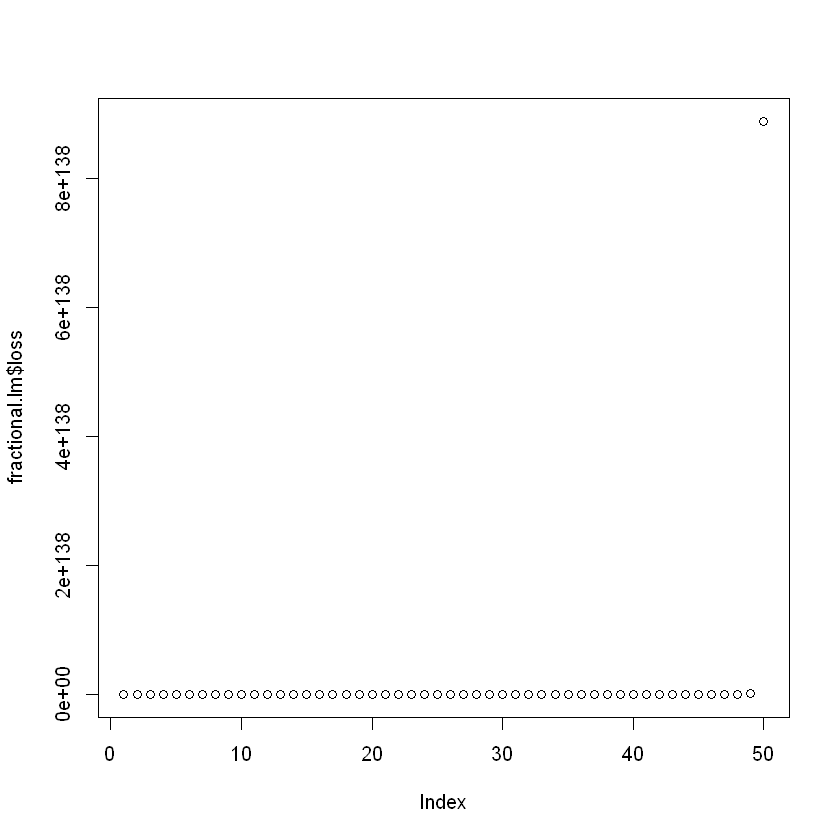

In [49]:
plot(fractional.lm$loss)